# SPARC-4 Pipeline Tools
## Night:``2023-06-04``
## Modes: ``POLARIMETRY``
***

This notebook shows an example of the full reduction of the SPARC4 data in the [minidata package](https://drive.google.com/file/d/1tAVjyhYGMDcrU5sDdGCmd_f5HoazZ294/view?usp=drive_link) using the SPARC4 pipeline tools. 

* Author: Eder Martioli, LNA 18 Apr 2024

In [1]:
import os, sys
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.utils as s4utils
import glob
import warnings
warnings.filterwarnings('ignore')

## User inputs and initial setup

Before starting the reduction, we must configure a few parameters. The pipeline comes with default values for all parameters. To modify these, one can create and edit their own parameter file, then load it into the ``PARAMS_FILE`` variable. Alternatively, parameters can be changed by directly resetting the dictionary entry for a specific parameter, like this: ``p['PARAM_NAME'] = PARAM_NEW_VALUE``. See examples below. 

In [2]:
# set night directory name
NIGHTDIR = '20230604'
# set raw data root directory
ROOTDATADIR =  "/Users/eder/Data/SPARC4/minidata/"
# set reduced data root directory
ROOTREDUCEDDIR = "/Users/eder/Data/SPARC4/minidata/reduced/"
# set reduced data root directory
PIPELINEDIR = "/Users/eder/sparc4-pipeline/"
# define path to default calibration directory
calibdb_dir = os.path.join(PIPELINEDIR, "calibdb/")

# select a SPARC4 channel: 1 (g), 2 (r), 3 (i) or 4 (z)
CHANNEL = 1  

# set path to a parameters file:
#PARAMS_FILE = ""  # to use deafult values
PARAMS_FILE = os.path.join(PIPELINEDIR,"user_files/my_params.yaml")

# set path to a target list file
# this is to force targets to be included in the source catalog in addition to those detected automatically
TARGET_LIST_FILE = os.path.join(PIPELINEDIR,"user_files/targets.csv")

# initialize pipeline parameters
p = s4pipelib.init_s4_p(NIGHTDIR,
                        ROOTDATADIR,
                        ROOTREDUCEDDIR,
                        print_report=False,
                        param_file=PARAMS_FILE)

# get data dir
datadir = p['data_directories'][CHANNEL-1]
# get reduce dir
reducedir = p['reduce_directories'][CHANNEL-1]

# to force reduction even if products already exist
FORCE = False

###############################################################
# Below are a few examples on how to manually reset parameters: 
###############################################################

# set astrometry reference image as the one for this channel
p["ASTROM_REF_IMG"] = os.path.join(calibdb_dir, p["ASTROM_REF_IMGS"][CHANNEL-1])

# to build stacks of 10 images instead of the default value of 16 images
p['NFILES_FOR_STACK'] = 10

# to change the S/N threshold for detecting sources
# -- note that lower values will result in more (fainter) sources being detected.
p['PHOT_THRESHOLD'] = 100


# Turn off flat per waveplate position, as for this dataset  
# there are only flats available for 1 flat position
p['APPLY_FLAT_PER_WPPOS'] = False

# uncomment below to print all parameters and their respective values:
#for key in p.keys():
#    print("p['{}']={}".format(key,p[key]))

***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

In this section we build the master bias and flat-field calibrations.

## Define input list and output master product file names

In [3]:
# create a list of zeros for current detector mode
zero_list = glob.glob("{}/{}".format(datadir,"*zero*.fits"))

# define file name of master bias 
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reducedir,
                                                        NIGHTDIR,
                                                        CHANNEL)

# create a list of flats for current detector mode
flat_list = glob.glob("{}/{}".format(datadir,"*dflat*.fits"))

# define file name of master flat
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reducedir,
                                                            NIGHTDIR,
                                                            CHANNEL)

# Run master calibration

The master calibration routine combines a list of calibration files into a master calibration image.

In [4]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     force=FORCE)

In [5]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     normalize=True, 
                                     force=FORCE)

# Plot master calibration results

Now, we plot the results to check if they look fine. 

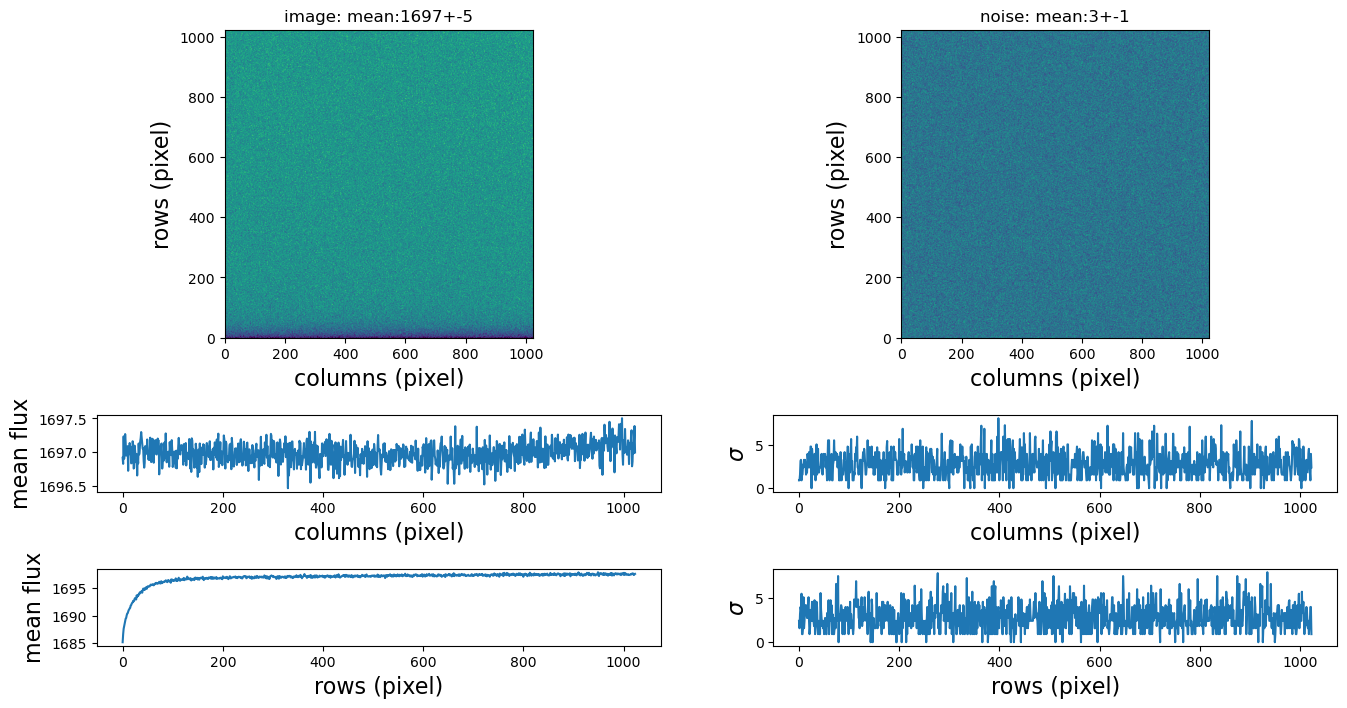

In [6]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

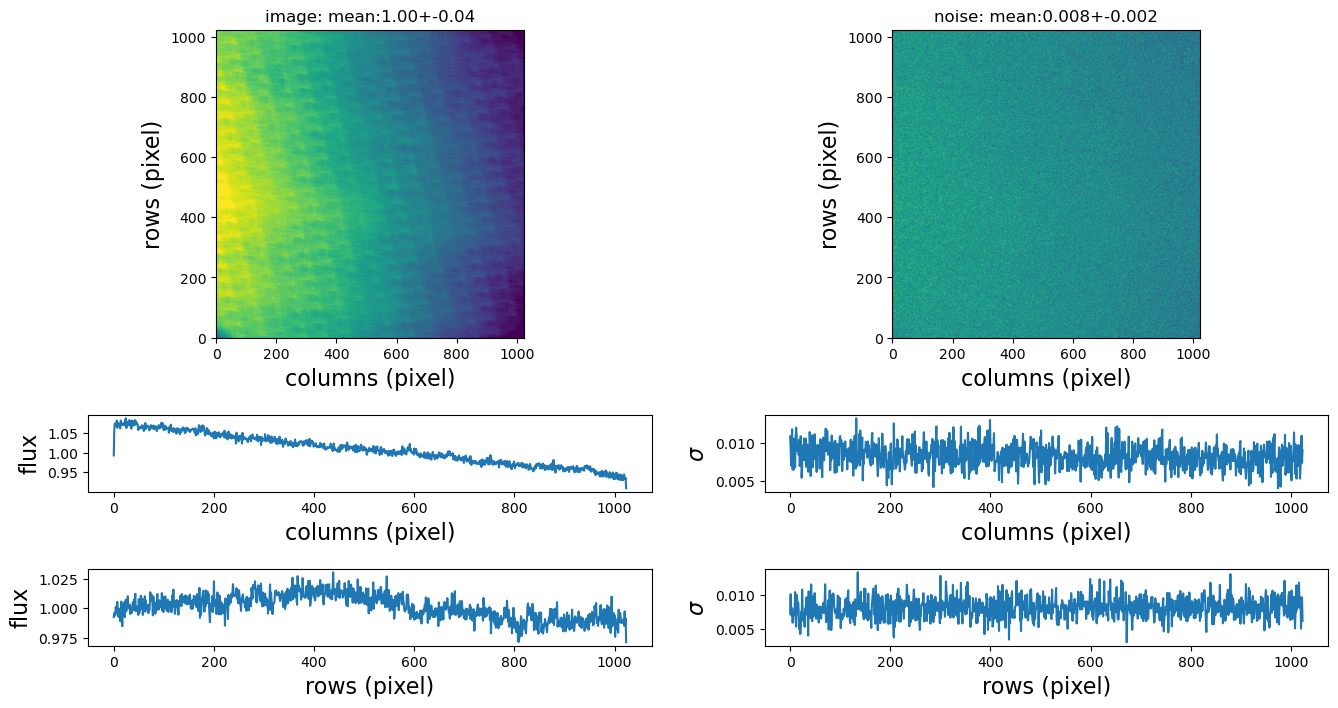

In [7]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)

***
# <font color='darkblue'>Science image reduction - Polarimetry</font> 

In this section we reduce the science data. In this example we show the reduction processes for the following observations:

* The polarimetric standard [Hilt 652](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Hilt+652&submit=SIMBAD+search) observed in polarimetric mode.  It was observed in 16 rotating positions of the waveplate, equally spaced by 22.5 degrees, utilizing both L/2 and L/4 waveplate retarders.

## Select Hilt 652 data

In [8]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "Hilt 652" # HD111579 is a polarimetric standard

# create a list of science data 
pol_list = glob.glob("{}/{}".format(datadir,"*stdpol.fits"))

# set instrument mode to "POLAR"
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']

FORCE = False

## Reduce scientific exposures in `POLARIMETRY HALF-WAVE (L/2)` mode

To reduce scientific frames, run the routine ``s4pipelib.stack_and_reduce_sci_images``. This routine performs calibration for detector gain, bias, and flat-field. Then, a subset of frames is stacked to generate a stack product. Source detection is then conducted within the stack frame, and the identified sources are cross-referenced with a catalog to establish an astrometric solution and generate a master catalog for all input observations of this field. The polarimetric pairs (dual beam) are matched and organized into two distinct catalogs. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into ``proc.fits`` product FITS files.

In [9]:
# initial set up
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l2_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of half-wave files (L2)
pol_l2_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L2')

2024-09-20 11:04:02,685 root - INFO - STACK: checking image 1 of 16: i=0 20230604_s4c1_000473_stdpol.fits -> NSOURCES: 17  bkg: 704.4386891953228 meanflux: 139754.34555522547   [pipeline_lib]


2024-09-20 11:04:02,685 | INFO | STACK: checking image 1 of 16: i=0 20230604_s4c1_000473_stdpol.fits -> NSOURCES: 17  bkg: 704.4386891953228 meanflux: 139754.34555522547 


2024-09-20 11:04:03,110 root - INFO - STACK: checking image 2 of 16: i=1 20230604_s4c1_000476_stdpol.fits -> NSOURCES: 21  bkg: 703.8252716279942 meanflux: 142125.17149583925   [pipeline_lib]


2024-09-20 11:04:03,110 | INFO | STACK: checking image 2 of 16: i=1 20230604_s4c1_000476_stdpol.fits -> NSOURCES: 21  bkg: 703.8252716279942 meanflux: 142125.17149583925 


2024-09-20 11:04:03,521 root - INFO - STACK: checking image 3 of 16: i=2 20230604_s4c1_000482_stdpol.fits -> NSOURCES: 22  bkg: 702.8484739649638 meanflux: 143656.81666263737   [pipeline_lib]


2024-09-20 11:04:03,521 | INFO | STACK: checking image 3 of 16: i=2 20230604_s4c1_000482_stdpol.fits -> NSOURCES: 22  bkg: 702.8484739649638 meanflux: 143656.81666263737 


2024-09-20 11:04:03,909 root - INFO - STACK: checking image 4 of 16: i=3 20230604_s4c1_000481_stdpol.fits -> NSOURCES: 18  bkg: 704.0229555617311 meanflux: 141306.75241578027   [pipeline_lib]


2024-09-20 11:04:03,909 | INFO | STACK: checking image 4 of 16: i=3 20230604_s4c1_000481_stdpol.fits -> NSOURCES: 18  bkg: 704.0229555617311 meanflux: 141306.75241578027 


2024-09-20 11:04:04,426 root - INFO - STACK: checking image 5 of 16: i=4 20230604_s4c1_000475_stdpol.fits -> NSOURCES: 21  bkg: 703.2964610650745 meanflux: 145199.16847767244   [pipeline_lib]


2024-09-20 11:04:04,426 | INFO | STACK: checking image 5 of 16: i=4 20230604_s4c1_000475_stdpol.fits -> NSOURCES: 21  bkg: 703.2964610650745 meanflux: 145199.16847767244 


2024-09-20 11:04:04,832 root - INFO - STACK: checking image 6 of 16: i=5 20230604_s4c1_000479_stdpol.fits -> NSOURCES: 22  bkg: 703.827198849229 meanflux: 143839.36193427633   [pipeline_lib]


2024-09-20 11:04:04,832 | INFO | STACK: checking image 6 of 16: i=5 20230604_s4c1_000479_stdpol.fits -> NSOURCES: 22  bkg: 703.827198849229 meanflux: 143839.36193427633 


2024-09-20 11:04:05,225 root - INFO - STACK: checking image 7 of 16: i=6 20230604_s4c1_000484_stdpol.fits -> NSOURCES: 22  bkg: 702.7775114991643 meanflux: 140384.13129493795   [pipeline_lib]


2024-09-20 11:04:05,225 | INFO | STACK: checking image 7 of 16: i=6 20230604_s4c1_000484_stdpol.fits -> NSOURCES: 22  bkg: 702.7775114991643 meanflux: 140384.13129493795 


2024-09-20 11:04:05,611 root - INFO - STACK: checking image 8 of 16: i=7 20230604_s4c1_000483_stdpol.fits -> NSOURCES: 22  bkg: 703.8189831075513 meanflux: 142883.16729409553   [pipeline_lib]


2024-09-20 11:04:05,611 | INFO | STACK: checking image 8 of 16: i=7 20230604_s4c1_000483_stdpol.fits -> NSOURCES: 22  bkg: 703.8189831075513 meanflux: 142883.16729409553 


2024-09-20 11:04:06,006 root - INFO - STACK: checking image 9 of 16: i=8 20230604_s4c1_000477_stdpol.fits -> NSOURCES: 17  bkg: 703.915950555361 meanflux: 141084.84895177546   [pipeline_lib]


2024-09-20 11:04:06,006 | INFO | STACK: checking image 9 of 16: i=8 20230604_s4c1_000477_stdpol.fits -> NSOURCES: 17  bkg: 703.915950555361 meanflux: 141084.84895177546 


2024-09-20 11:04:06,443 root - INFO - STACK: checking image 10 of 16: i=9 20230604_s4c1_000472_stdpol.fits -> NSOURCES: 22  bkg: 702.9591383354223 meanflux: 143312.81804430165   [pipeline_lib]


2024-09-20 11:04:06,443 | INFO | STACK: checking image 10 of 16: i=9 20230604_s4c1_000472_stdpol.fits -> NSOURCES: 22  bkg: 702.9591383354223 meanflux: 143312.81804430165 


2024-09-20 11:04:06,830 root - INFO - STACK: checking image 11 of 16: i=10 20230604_s4c1_000486_stdpol.fits -> NSOURCES: 22  bkg: 703.2714547010492 meanflux: 142940.9192058389   [pipeline_lib]


2024-09-20 11:04:06,830 | INFO | STACK: checking image 11 of 16: i=10 20230604_s4c1_000486_stdpol.fits -> NSOURCES: 22  bkg: 703.2714547010492 meanflux: 142940.9192058389 


2024-09-20 11:04:07,233 root - INFO - STACK: checking image 12 of 16: i=11 20230604_s4c1_000485_stdpol.fits -> NSOURCES: 22  bkg: 701.9073753467036 meanflux: 141586.2818743891   [pipeline_lib]


2024-09-20 11:04:07,233 | INFO | STACK: checking image 12 of 16: i=11 20230604_s4c1_000485_stdpol.fits -> NSOURCES: 22  bkg: 701.9073753467036 meanflux: 141586.2818743891 


2024-09-20 11:04:07,612 root - INFO - STACK: checking image 13 of 16: i=12 20230604_s4c1_000478_stdpol.fits -> NSOURCES: 20  bkg: 703.2813540689676 meanflux: 142322.56543209415   [pipeline_lib]


2024-09-20 11:04:07,612 | INFO | STACK: checking image 13 of 16: i=12 20230604_s4c1_000478_stdpol.fits -> NSOURCES: 20  bkg: 703.2813540689676 meanflux: 142322.56543209415 


2024-09-20 11:04:08,060 root - INFO - STACK: checking image 14 of 16: i=13 20230604_s4c1_000471_stdpol.fits -> NSOURCES: 22  bkg: 703.608690587371 meanflux: 143447.36367198182   [pipeline_lib]


2024-09-20 11:04:08,060 | INFO | STACK: checking image 14 of 16: i=13 20230604_s4c1_000471_stdpol.fits -> NSOURCES: 22  bkg: 703.608690587371 meanflux: 143447.36367198182 


2024-09-20 11:04:08,477 root - INFO - STACK: checking image 15 of 16: i=14 20230604_s4c1_000474_stdpol.fits -> NSOURCES: 22  bkg: 704.9542696478862 meanflux: 142990.001999331   [pipeline_lib]


2024-09-20 11:04:08,477 | INFO | STACK: checking image 15 of 16: i=14 20230604_s4c1_000474_stdpol.fits -> NSOURCES: 22  bkg: 704.9542696478862 meanflux: 142990.001999331 


2024-09-20 11:04:08,880 root - INFO - STACK: checking image 16 of 16: i=15 20230604_s4c1_000480_stdpol.fits -> NSOURCES: 22  bkg: 703.2893898139241 meanflux: 143352.48657712046   [pipeline_lib]


2024-09-20 11:04:08,880 | INFO | STACK: checking image 16 of 16: i=15 20230604_s4c1_000480_stdpol.fits -> NSOURCES: 22  bkg: 703.2893898139241 meanflux: 143352.48657712046 


2024-09-20 11:04:08,883 root - INFO - Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:08,883 | INFO | Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits


2024-09-20 11:04:08,901 root - INFO - OBJECT files: 10  [pipeline_lib]


2024-09-20 11:04:08,901 | INFO | OBJECT files: 10


2024-09-20 11:04:08,902 root - INFO - Loading science frames to memory ...   [pipeline_lib]


2024-09-20 11:04:08,902 | INFO | Loading science frames to memory ... 


2024-09-20 11:04:08,998 root - INFO - gain:3.37 electron / adu  [pipeline_lib]


2024-09-20 11:04:08,998 | INFO | gain:3.37 electron / adu


2024-09-20 11:04:08,999 root - INFO - Calibrating science frames (CR, gain, bias, flat) for stack ...   [pipeline_lib]


2024-09-20 11:04:08,999 | INFO | Calibrating science frames (CR, gain, bias, flat) for stack ... 


2024-09-20 11:04:08,999 root - INFO - Calibrating science frame 1 of 10 : 20230604_s4c1_000473_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:08,999 | INFO | Calibrating science frame 1 of 10 : 20230604_s4c1_000473_stdpol.fits 


2024-09-20 11:04:09,381 root - INFO - Calibrating science frame 2 of 10 : 20230604_s4c1_000486_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:09,381 | INFO | Calibrating science frame 2 of 10 : 20230604_s4c1_000486_stdpol.fits 


2024-09-20 11:04:09,744 root - INFO - Calibrating science frame 3 of 10 : 20230604_s4c1_000478_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:09,744 | INFO | Calibrating science frame 3 of 10 : 20230604_s4c1_000478_stdpol.fits 


2024-09-20 11:04:10,105 root - INFO - Calibrating science frame 4 of 10 : 20230604_s4c1_000476_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:10,105 | INFO | Calibrating science frame 4 of 10 : 20230604_s4c1_000476_stdpol.fits 


2024-09-20 11:04:10,471 root - INFO - Calibrating science frame 5 of 10 : 20230604_s4c1_000472_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:10,471 | INFO | Calibrating science frame 5 of 10 : 20230604_s4c1_000472_stdpol.fits 


2024-09-20 11:04:10,837 root - INFO - Calibrating science frame 6 of 10 : 20230604_s4c1_000480_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:10,837 | INFO | Calibrating science frame 6 of 10 : 20230604_s4c1_000480_stdpol.fits 


2024-09-20 11:04:11,206 root - INFO - Calibrating science frame 7 of 10 : 20230604_s4c1_000474_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:11,206 | INFO | Calibrating science frame 7 of 10 : 20230604_s4c1_000474_stdpol.fits 


2024-09-20 11:04:11,576 root - INFO - Calibrating science frame 8 of 10 : 20230604_s4c1_000482_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:11,576 | INFO | Calibrating science frame 8 of 10 : 20230604_s4c1_000482_stdpol.fits 


2024-09-20 11:04:11,973 root - INFO - Calibrating science frame 9 of 10 : 20230604_s4c1_000484_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:11,973 | INFO | Calibrating science frame 9 of 10 : 20230604_s4c1_000484_stdpol.fits 


2024-09-20 11:04:12,351 root - INFO - Calibrating science frame 10 of 10 : 20230604_s4c1_000481_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:12,351 | INFO | Calibrating science frame 10 of 10 : 20230604_s4c1_000481_stdpol.fits 


2024-09-20 11:04:12,720 root - INFO - Registering science frames and stacking them ...   [pipeline_lib]


2024-09-20 11:04:12,720 | INFO | Registering science frames and stacking them ... 


2024-09-20 11:04:12,721 root - INFO - Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,721 | INFO | Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits


2024-09-20 11:04:12,723 root - INFO - Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000486_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,723 | INFO | Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000486_stdpol.fits


2024-09-20 11:04:12,725 root - INFO - Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000478_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,725 | INFO | Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000478_stdpol.fits


2024-09-20 11:04:12,727 root - INFO - Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000476_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,727 | INFO | Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000476_stdpol.fits


2024-09-20 11:04:12,729 root - INFO - Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000472_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,729 | INFO | Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000472_stdpol.fits


2024-09-20 11:04:12,730 root - INFO - Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000480_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,730 | INFO | Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000480_stdpol.fits


2024-09-20 11:04:12,732 root - INFO - Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000474_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,732 | INFO | Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000474_stdpol.fits


2024-09-20 11:04:12,735 root - INFO - Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000482_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,735 | INFO | Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000482_stdpol.fits


2024-09-20 11:04:12,737 root - INFO - Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000484_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,737 | INFO | Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000484_stdpol.fits


2024-09-20 11:04:12,739 root - INFO - Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000481_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:12,739 | INFO | Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000481_stdpol.fits


2024-09-20 11:04:12,743 astropop - INFO - Registering image 1 from 10  [register]


2024-09-20 11:04:12,743 | INFO | Registering image 1 from 10


2024-09-20 11:04:12,745 astropop - INFO - Images are equal, skipping registering.  [register]


2024-09-20 11:04:12,745 | INFO | Images are equal, skipping registering.


2024-09-20 11:04:12,834 astropop - INFO - Registering image 2 from 10  [register]


2024-09-20 11:04:12,834 | INFO | Registering image 2 from 10


2024-09-20 11:04:12,922 astropop - INFO - Filling registered image with cval=668.21  [register]


2024-09-20 11:04:12,922 | INFO | Filling registered image with cval=668.21


2024-09-20 11:04:12,928 astropop - INFO - Registering image with: translation=[-0.   -0.25], rotation=0.00°  [register]


2024-09-20 11:04:12,928 | INFO | Registering image with: translation=[-0.   -0.25], rotation=0.00°


2024-09-20 11:04:13,049 astropop - INFO - Registering image 3 from 10  [register]


2024-09-20 11:04:13,049 | INFO | Registering image 3 from 10


2024-09-20 11:04:13,155 astropop - INFO - Filling registered image with cval=667.93  [register]


2024-09-20 11:04:13,155 | INFO | Filling registered image with cval=667.93


2024-09-20 11:04:13,164 astropop - INFO - Registering image with: translation=[-0.25 -0.25], rotation=0.00°  [register]


2024-09-20 11:04:13,164 | INFO | Registering image with: translation=[-0.25 -0.25], rotation=0.00°


2024-09-20 11:04:13,285 astropop - INFO - Registering image 4 from 10  [register]


2024-09-20 11:04:13,285 | INFO | Registering image 4 from 10


2024-09-20 11:04:13,369 astropop - INFO - Filling registered image with cval=670.05  [register]


2024-09-20 11:04:13,369 | INFO | Filling registered image with cval=670.05


2024-09-20 11:04:13,376 astropop - INFO - Registering image with: translation=[-1.   -0.25], rotation=0.00°  [register]


2024-09-20 11:04:13,376 | INFO | Registering image with: translation=[-1.   -0.25], rotation=0.00°


2024-09-20 11:04:13,491 astropop - INFO - Registering image 5 from 10  [register]


2024-09-20 11:04:13,491 | INFO | Registering image 5 from 10


2024-09-20 11:04:13,585 astropop - INFO - Filling registered image with cval=666.95  [register]


2024-09-20 11:04:13,585 | INFO | Filling registered image with cval=666.95


2024-09-20 11:04:13,596 astropop - INFO - Registering image with: translation=[-0.5 -0. ], rotation=0.00°  [register]


2024-09-20 11:04:13,596 | INFO | Registering image with: translation=[-0.5 -0. ], rotation=0.00°


2024-09-20 11:04:13,721 astropop - INFO - Registering image 6 from 10  [register]


2024-09-20 11:04:13,721 | INFO | Registering image 6 from 10


2024-09-20 11:04:13,800 astropop - INFO - Filling registered image with cval=668.22  [register]


2024-09-20 11:04:13,800 | INFO | Filling registered image with cval=668.22


2024-09-20 11:04:13,810 astropop - INFO - Registering image with: translation=[-1.   -0.75], rotation=0.00°  [register]


2024-09-20 11:04:13,810 | INFO | Registering image with: translation=[-1.   -0.75], rotation=0.00°


2024-09-20 11:04:13,942 astropop - INFO - Registering image 7 from 10  [register]


2024-09-20 11:04:13,942 | INFO | Registering image 7 from 10


2024-09-20 11:04:14,054 astropop - INFO - Filling registered image with cval=672.60  [register]


2024-09-20 11:04:14,054 | INFO | Filling registered image with cval=672.60


2024-09-20 11:04:14,074 astropop - INFO - Registering image with: translation=[ 1. -0.], rotation=0.00°  [register]


2024-09-20 11:04:14,074 | INFO | Registering image with: translation=[ 1. -0.], rotation=0.00°


2024-09-20 11:04:14,214 astropop - INFO - Registering image 8 from 10  [register]


2024-09-20 11:04:14,214 | INFO | Registering image 8 from 10


2024-09-20 11:04:14,305 astropop - INFO - Filling registered image with cval=666.52  [register]


2024-09-20 11:04:14,305 | INFO | Filling registered image with cval=666.52


2024-09-20 11:04:14,309 astropop - INFO - Registering image with: translation=[-0.25 -1.  ], rotation=0.00°  [register]


2024-09-20 11:04:14,309 | INFO | Registering image with: translation=[-0.25 -1.  ], rotation=0.00°


2024-09-20 11:04:14,435 astropop - INFO - Registering image 9 from 10  [register]


2024-09-20 11:04:14,435 | INFO | Registering image 9 from 10


2024-09-20 11:04:14,530 astropop - INFO - Filling registered image with cval=666.24  [register]


2024-09-20 11:04:14,530 | INFO | Filling registered image with cval=666.24


2024-09-20 11:04:14,548 astropop - INFO - Registering image with: translation=[ 0.5  -0.75], rotation=0.00°  [register]


2024-09-20 11:04:14,548 | INFO | Registering image with: translation=[ 0.5  -0.75], rotation=0.00°


2024-09-20 11:04:14,678 astropop - INFO - Registering image 10 from 10  [register]


2024-09-20 11:04:14,678 | INFO | Registering image 10 from 10


2024-09-20 11:04:14,770 astropop - INFO - Filling registered image with cval=670.35  [register]


2024-09-20 11:04:14,770 | INFO | Filling registered image with cval=670.35


2024-09-20 11:04:14,778 astropop - INFO - Registering image with: translation=[-1.  -0.5], rotation=0.00°  [register]


2024-09-20 11:04:14,778 | INFO | Registering image with: translation=[-1.  -0.5], rotation=0.00°


2024-09-20 11:04:14,950 astropop - INFO - Combining 10 images with mean method.  [imcombine]


2024-09-20 11:04:14,950 | INFO | Combining 10 images with mean method.


2024-09-20 11:04:16,170 root - INFO - Creating new catalog of detected sources:  [pipeline_lib]


2024-09-20 11:04:16,170 | INFO | Creating new catalog of detected sources:


2024-09-20 11:04:16,276 root - INFO - Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()  [pipeline_lib]


2024-09-20 11:04:16,276 | INFO | Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()


2024-09-20 11:04:16,277 root - INFO - No sky coordinates given, searching sources in online catalogs  [pipeline_lib]


2024-09-20 11:04:16,277 | INFO | No sky coordinates given, searching sources in online catalogs


2024-09-20 11:04:16,278 root - INFO - Querying Gaia DR3 using twirl  [pipeline_lib]


2024-09-20 11:04:16,278 | INFO | Querying Gaia DR3 using twirl


2024-09-20 11:04:18,648 root - INFO - Matching sources with catalog and solving astrometry to compute WCS  [pipeline_lib]


2024-09-20 11:04:18,648 | INFO | Matching sources with catalog and solving astrometry to compute WCS


2024-09-20 11:04:18,967 root - INFO - Running photometry for multiple apertures:  [pipeline_lib]


2024-09-20 11:04:18,967 | INFO | Running photometry for multiple apertures:


2024-09-20 11:04:18,968 root - INFO - Aperture radius of 5 pixels: 1 of 7 :  [pipeline_lib]


2024-09-20 11:04:18,968 | INFO | Aperture radius of 5 pixels: 1 of 7 :


2024-09-20 11:04:19,072 root - INFO - Aperture radius of 8 pixels: 2 of 7 :  [pipeline_lib]


2024-09-20 11:04:19,072 | INFO | Aperture radius of 8 pixels: 2 of 7 :


2024-09-20 11:04:19,174 root - INFO - Aperture radius of 10 pixels: 3 of 7 :  [pipeline_lib]


2024-09-20 11:04:19,174 | INFO | Aperture radius of 10 pixels: 3 of 7 :


2024-09-20 11:04:19,275 root - INFO - Aperture radius of 12 pixels: 4 of 7 :  [pipeline_lib]


2024-09-20 11:04:19,275 | INFO | Aperture radius of 12 pixels: 4 of 7 :


2024-09-20 11:04:19,377 root - INFO - Aperture radius of 15 pixels: 5 of 7 :  [pipeline_lib]


2024-09-20 11:04:19,377 | INFO | Aperture radius of 15 pixels: 5 of 7 :


2024-09-20 11:04:19,489 root - INFO - Aperture radius of 20 pixels: 6 of 7 :  [pipeline_lib]


2024-09-20 11:04:19,489 | INFO | Aperture radius of 20 pixels: 6 of 7 :


2024-09-20 11:04:19,597 root - INFO - Aperture radius of 25 pixels: 7 of 7 :  [pipeline_lib]


2024-09-20 11:04:19,597 | INFO | Aperture radius of 25 pixels: 7 of 7 :


2024-09-20 11:04:20,179 root - INFO - The 16 images will be reduced in 1 loops of 100 images each time  [pipeline_lib]


2024-09-20 11:04:20,179 | INFO | The 16 images will be reduced in 1 loops of 100 images each time


2024-09-20 11:04:20,180 root - INFO - Running loop 0 of 1 -> images in loop: 0 to 16 ...   [pipeline_lib]


2024-09-20 11:04:20,180 | INFO | Running loop 0 of 1 -> images in loop: 0 to 16 ... 


2024-09-20 11:04:20,308 root - INFO - OBJECT files: 17  [pipeline_lib]


2024-09-20 11:04:20,308 | INFO | OBJECT files: 17


2024-09-20 11:04:20,308 root - INFO - Creating output list of processed science frames ...   [pipeline_lib]


2024-09-20 11:04:20,308 | INFO | Creating output list of processed science frames ... 


2024-09-20 11:04:20,309 root - INFO - 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000473_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,309 | INFO | 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000473_stdpol_proc.fits


2024-09-20 11:04:20,310 root - INFO - 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000473_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,310 | INFO | 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000473_stdpol_proc.fits


2024-09-20 11:04:20,310 root - INFO - 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000476_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,310 | INFO | 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000476_stdpol_proc.fits


2024-09-20 11:04:20,311 root - INFO - 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000482_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,311 | INFO | 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000482_stdpol_proc.fits


2024-09-20 11:04:20,311 root - INFO - 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000481_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,311 | INFO | 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000481_stdpol_proc.fits


2024-09-20 11:04:20,312 root - INFO - 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000475_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,312 | INFO | 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000475_stdpol_proc.fits


2024-09-20 11:04:20,312 root - INFO - 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000479_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,312 | INFO | 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000479_stdpol_proc.fits


2024-09-20 11:04:20,313 root - INFO - 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000484_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,313 | INFO | 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000484_stdpol_proc.fits


2024-09-20 11:04:20,313 root - INFO - 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000483_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,313 | INFO | 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000483_stdpol_proc.fits


2024-09-20 11:04:20,314 root - INFO - 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000477_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,314 | INFO | 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000477_stdpol_proc.fits


2024-09-20 11:04:20,314 root - INFO - 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000472_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,314 | INFO | 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000472_stdpol_proc.fits


2024-09-20 11:04:20,315 root - INFO - 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000486_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,315 | INFO | 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000486_stdpol_proc.fits


2024-09-20 11:04:20,315 root - INFO - 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000485_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,315 | INFO | 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000485_stdpol_proc.fits


2024-09-20 11:04:20,316 root - INFO - 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000478_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,316 | INFO | 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000478_stdpol_proc.fits


2024-09-20 11:04:20,316 root - INFO - 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000471_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,316 | INFO | 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000471_stdpol_proc.fits


2024-09-20 11:04:20,317 root - INFO - 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000474_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,317 | INFO | 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000474_stdpol_proc.fits


2024-09-20 11:04:20,317 root - INFO - 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000480_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:20,317 | INFO | 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000480_stdpol_proc.fits


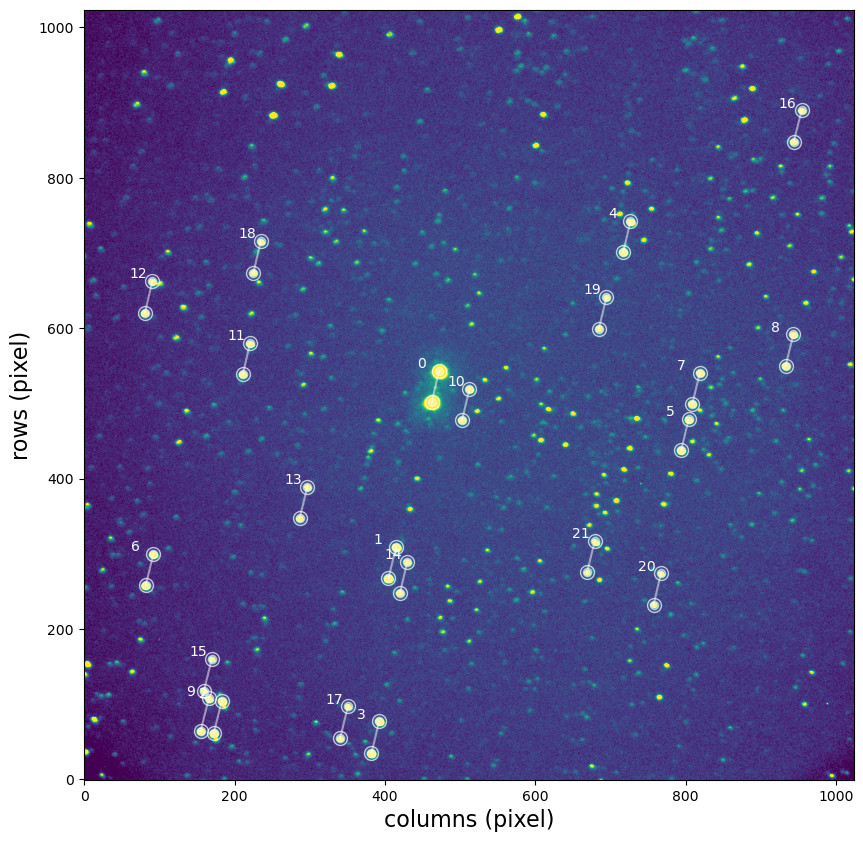

In [10]:
# run stack and reduce individual science image frames (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l2_list,
                                          reducedir,
                                          stack_suffix=l2_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                                                                        
                                          plot=True) 

## Calculate `HALF-WAVE (L/2)` POLARIMETRY

The half-wave ($\lambda/2$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [11]:
# input reduced files list
red_pol_l2_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l2_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l2_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


2024-09-20 11:04:20,697 root - INFO - There is already a polarimetry product :  [pipeline_lib]


2024-09-20 11:04:20,697 | INFO | There is already a polarimetry product :


2024-09-20 11:04:20,831 root - INFO - Source index: i=0   [pipeline_lib]


2024-09-20 11:04:20,831 | INFO | Source index: i=0 


2024-09-20 11:04:20,832 root - INFO - Source RA=280.00695774017083 Dec=-12.40187863097102 mag=-15.9397+-0.0003  [pipeline_lib]


2024-09-20 11:04:20,832 | INFO | Source RA=280.00695774017083 Dec=-12.40187863097102 mag=-15.9397+-0.0003


2024-09-20 11:04:20,832 root - INFO - Best aperture radius: 25.0 pixels  [pipeline_lib]


2024-09-20 11:04:20,832 | INFO | Best aperture radius: 25.0 pixels


2024-09-20 11:04:20,832 root - INFO - Polarization in Q: -0.0388+-0.0002  [pipeline_lib]


2024-09-20 11:04:20,832 | INFO | Polarization in Q: -0.0388+-0.0002


2024-09-20 11:04:20,833 root - INFO - Polarization in U: 0.0188+-0.0002  [pipeline_lib]


2024-09-20 11:04:20,833 | INFO | Polarization in U: 0.0188+-0.0002


2024-09-20 11:04:20,833 root - INFO - Polarization in V: nan+-nan  [pipeline_lib]


2024-09-20 11:04:20,833 | INFO | Polarization in V: nan+-nan


2024-09-20 11:04:20,834 root - INFO - Total linear polarization p: 0.0431+-0.0002  [pipeline_lib]


2024-09-20 11:04:20,834 | INFO | Total linear polarization p: 0.0431+-0.0002


2024-09-20 11:04:20,834 root - INFO - Angle of polarization theta: 77.1+-0.2  [pipeline_lib]


2024-09-20 11:04:20,834 | INFO | Angle of polarization theta: 77.1+-0.2


2024-09-20 11:04:20,835 root - INFO - Free constant k: 1+-nan  [pipeline_lib]


2024-09-20 11:04:20,835 | INFO | Free constant k: 1+-nan


2024-09-20 11:04:20,835 root - INFO - Zero of polarization: 0.0+-0.0  [pipeline_lib]


2024-09-20 11:04:20,835 | INFO | Zero of polarization: 0.0+-0.0


2024-09-20 11:04:20,836 root - INFO - RMS of zi residuals: 0.0006015453087781186  [pipeline_lib]


2024-09-20 11:04:20,836 | INFO | RMS of zi residuals: 0.0006015453087781186


2024-09-20 11:04:20,836 root - INFO - Reduced chi-square (n=16.0, DOF=14.0): 0.39  [pipeline_lib]


2024-09-20 11:04:20,836 | INFO | Reduced chi-square (n=16.0, DOF=14.0): 0.39


2024-09-20 11:04:20,884 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:20,884 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:20,887 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:20,887 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:20,995 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:20,995 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:20,998 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:20,998 | INFO | Substituting symbol \perp from STIXGeneral


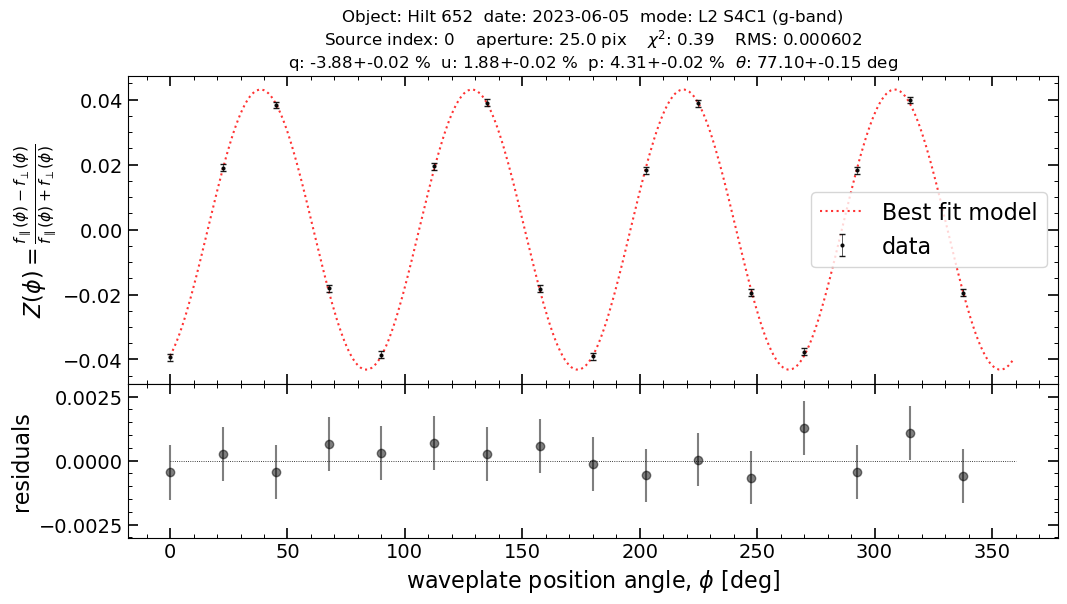

In [12]:
l2_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key = 'WPPOS',
                                                 wave_plate = 'halfwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = True,
                                                 fit_zero = False,
                                                 force = FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    
    l2_polar_products.append(polarproduct)

## Time series of `HALF-WAVE (L/2)` polarimetry data

In this section, we compile all selected polarimetric sequences into a time series product using the routine ``s4pipelib.polar_time_series``. However, for this particular example, since there is only one polarimetric sequence, the time series is not particularly relevant, as it contains only one point in time.

In [13]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)    

# Calculate polarimetric time series (ts) and save results to ts product
PolarTimeSeriesProduct = s4pipelib.polar_time_series(l2_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

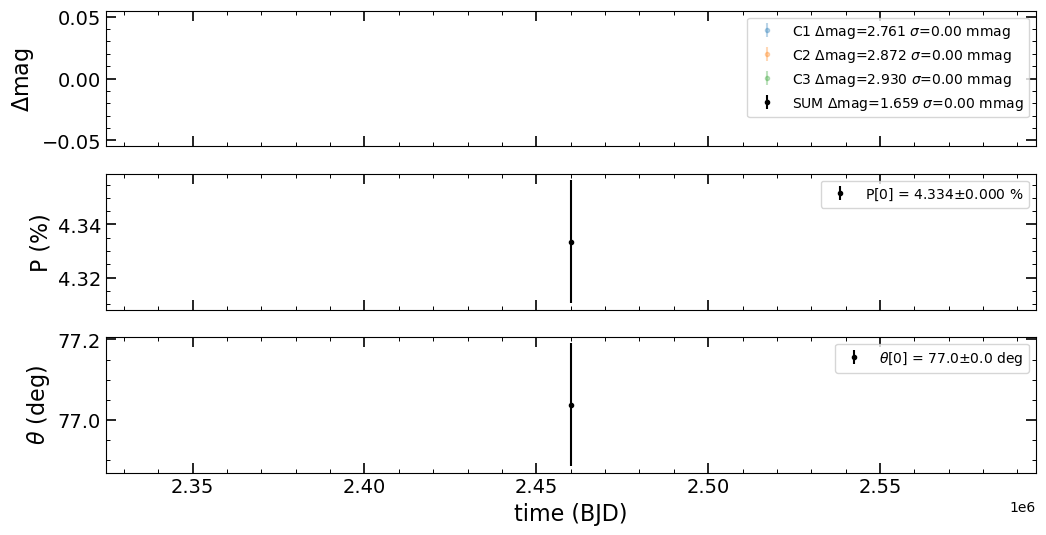

<Table length=1>
diffmag_C00000   diffmag_err_C00000  diffmag_C00001 ...   polarization_2   polarization_2_err
   float64            float64           float64     ...      float64            float64      
-------------- --------------------- -------------- ... ----------------- -------------------
           0.0 0.0013182968844090111            0.0 ... 77.03773109719779 0.15363521023407903

In [14]:
# plot polarimetric time series product
#   in this example the time series has only 1 point
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)

## Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE (L/4)` mode

Now repeat all the reduction procedures above for the L/4 data.

In [15]:
# initial set up
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l4_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of quarter-wave files (L4)
pol_l4_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L4')

2024-09-20 11:04:21,829 root - INFO - STACK: checking image 1 of 16: i=0 20230604_s4c1_000487_stdpol.fits -> NSOURCES: 22  bkg: 697.6877638047403 meanflux: 141104.8100250969   [pipeline_lib]


2024-09-20 11:04:21,829 | INFO | STACK: checking image 1 of 16: i=0 20230604_s4c1_000487_stdpol.fits -> NSOURCES: 22  bkg: 697.6877638047403 meanflux: 141104.8100250969 


2024-09-20 11:04:22,303 root - INFO - STACK: checking image 2 of 16: i=1 20230604_s4c1_000492_stdpol.fits -> NSOURCES: 22  bkg: 697.9641583016944 meanflux: 139502.1742273161   [pipeline_lib]


2024-09-20 11:04:22,303 | INFO | STACK: checking image 2 of 16: i=1 20230604_s4c1_000492_stdpol.fits -> NSOURCES: 22  bkg: 697.9641583016944 meanflux: 139502.1742273161 


2024-09-20 11:04:22,741 root - INFO - STACK: checking image 3 of 16: i=2 20230604_s4c1_000497_stdpol.fits -> NSOURCES: 22  bkg: 692.4540993500481 meanflux: 140518.66569920725   [pipeline_lib]


2024-09-20 11:04:22,741 | INFO | STACK: checking image 3 of 16: i=2 20230604_s4c1_000497_stdpol.fits -> NSOURCES: 22  bkg: 692.4540993500481 meanflux: 140518.66569920725 


2024-09-20 11:04:23,242 root - INFO - STACK: checking image 4 of 16: i=3 20230604_s4c1_000501_stdpol.fits -> NSOURCES: 22  bkg: 692.9336426545656 meanflux: 139863.4858861223   [pipeline_lib]


2024-09-20 11:04:23,242 | INFO | STACK: checking image 4 of 16: i=3 20230604_s4c1_000501_stdpol.fits -> NSOURCES: 22  bkg: 692.9336426545656 meanflux: 139863.4858861223 


2024-09-20 11:04:23,696 root - INFO - STACK: checking image 5 of 16: i=4 20230604_s4c1_000502_stdpol.fits -> NSOURCES: 22  bkg: 691.9429079237443 meanflux: 140305.20313067708   [pipeline_lib]


2024-09-20 11:04:23,696 | INFO | STACK: checking image 5 of 16: i=4 20230604_s4c1_000502_stdpol.fits -> NSOURCES: 22  bkg: 691.9429079237443 meanflux: 140305.20313067708 


2024-09-20 11:04:24,245 root - INFO - STACK: checking image 6 of 16: i=5 20230604_s4c1_000494_stdpol.fits -> NSOURCES: 16  bkg: 696.4671903588505 meanflux: 141048.62725218883   [pipeline_lib]


2024-09-20 11:04:24,245 | INFO | STACK: checking image 6 of 16: i=5 20230604_s4c1_000494_stdpol.fits -> NSOURCES: 16  bkg: 696.4671903588505 meanflux: 141048.62725218883 


2024-09-20 11:04:24,642 root - INFO - STACK: checking image 7 of 16: i=6 20230604_s4c1_000488_stdpol.fits -> NSOURCES: 19  bkg: 697.4719316919993 meanflux: 138696.8309520879   [pipeline_lib]


2024-09-20 11:04:24,642 | INFO | STACK: checking image 7 of 16: i=6 20230604_s4c1_000488_stdpol.fits -> NSOURCES: 19  bkg: 697.4719316919993 meanflux: 138696.8309520879 


2024-09-20 11:04:25,141 root - INFO - STACK: checking image 8 of 16: i=7 20230604_s4c1_000491_stdpol.fits -> NSOURCES: 21  bkg: 698.4926402559773 meanflux: 140623.6798439102   [pipeline_lib]


2024-09-20 11:04:25,141 | INFO | STACK: checking image 8 of 16: i=7 20230604_s4c1_000491_stdpol.fits -> NSOURCES: 21  bkg: 698.4926402559773 meanflux: 140623.6798439102 


2024-09-20 11:04:25,596 root - INFO - STACK: checking image 9 of 16: i=8 20230604_s4c1_000498_stdpol.fits -> NSOURCES: 22  bkg: 693.5086442837852 meanflux: 140542.4824376826   [pipeline_lib]


2024-09-20 11:04:25,596 | INFO | STACK: checking image 9 of 16: i=8 20230604_s4c1_000498_stdpol.fits -> NSOURCES: 22  bkg: 693.5086442837852 meanflux: 140542.4824376826 


2024-09-20 11:04:26,003 root - INFO - STACK: checking image 10 of 16: i=9 20230604_s4c1_000500_stdpol.fits -> NSOURCES: 21  bkg: 692.701571570829 meanflux: 138769.51263689352   [pipeline_lib]


2024-09-20 11:04:26,003 | INFO | STACK: checking image 10 of 16: i=9 20230604_s4c1_000500_stdpol.fits -> NSOURCES: 21  bkg: 692.701571570829 meanflux: 138769.51263689352 


2024-09-20 11:04:26,492 root - INFO - STACK: checking image 11 of 16: i=10 20230604_s4c1_000496_stdpol.fits -> NSOURCES: 22  bkg: 693.4716407365361 meanflux: 140741.32122501283   [pipeline_lib]


2024-09-20 11:04:26,492 | INFO | STACK: checking image 11 of 16: i=10 20230604_s4c1_000496_stdpol.fits -> NSOURCES: 22  bkg: 693.4716407365361 meanflux: 140741.32122501283 


2024-09-20 11:04:27,029 root - INFO - STACK: checking image 12 of 16: i=11 20230604_s4c1_000493_stdpol.fits -> NSOURCES: 17  bkg: 697.4186842263616 meanflux: 139524.6081045603   [pipeline_lib]


2024-09-20 11:04:27,029 | INFO | STACK: checking image 12 of 16: i=11 20230604_s4c1_000493_stdpol.fits -> NSOURCES: 17  bkg: 697.4186842263616 meanflux: 139524.6081045603 


2024-09-20 11:04:27,410 root - INFO - STACK: checking image 13 of 16: i=12 20230604_s4c1_000499_stdpol.fits -> NSOURCES: 22  bkg: 693.4490200878331 meanflux: 137859.21121739814   [pipeline_lib]


2024-09-20 11:04:27,410 | INFO | STACK: checking image 13 of 16: i=12 20230604_s4c1_000499_stdpol.fits -> NSOURCES: 22  bkg: 693.4490200878331 meanflux: 137859.21121739814 


2024-09-20 11:04:27,884 root - INFO - STACK: checking image 14 of 16: i=13 20230604_s4c1_000490_stdpol.fits -> NSOURCES: 20  bkg: 698.465410861525 meanflux: 140112.70049204148   [pipeline_lib]


2024-09-20 11:04:27,884 | INFO | STACK: checking image 14 of 16: i=13 20230604_s4c1_000490_stdpol.fits -> NSOURCES: 20  bkg: 698.465410861525 meanflux: 140112.70049204148 


2024-09-20 11:04:28,314 root - INFO - STACK: checking image 15 of 16: i=14 20230604_s4c1_000489_stdpol.fits -> NSOURCES: 16  bkg: 698.0733861844208 meanflux: 138461.04568561423   [pipeline_lib]


2024-09-20 11:04:28,314 | INFO | STACK: checking image 15 of 16: i=14 20230604_s4c1_000489_stdpol.fits -> NSOURCES: 16  bkg: 698.0733861844208 meanflux: 138461.04568561423 


2024-09-20 11:04:28,799 root - INFO - STACK: checking image 16 of 16: i=15 20230604_s4c1_000495_stdpol.fits -> NSOURCES: 20  bkg: 693.5939542905194 meanflux: 141166.99974035335   [pipeline_lib]


2024-09-20 11:04:28,799 | INFO | STACK: checking image 16 of 16: i=15 20230604_s4c1_000495_stdpol.fits -> NSOURCES: 20  bkg: 693.5939542905194 meanflux: 141166.99974035335 


2024-09-20 11:04:28,802 root - INFO - Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:28,802 | INFO | Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits


2024-09-20 11:04:28,821 root - INFO - OBJECT files: 10  [pipeline_lib]


2024-09-20 11:04:28,821 | INFO | OBJECT files: 10


2024-09-20 11:04:28,821 root - INFO - Loading science frames to memory ...   [pipeline_lib]


2024-09-20 11:04:28,821 | INFO | Loading science frames to memory ... 


2024-09-20 11:04:28,931 root - INFO - gain:3.37 electron / adu  [pipeline_lib]


2024-09-20 11:04:28,931 | INFO | gain:3.37 electron / adu


2024-09-20 11:04:28,932 root - INFO - Calibrating science frames (CR, gain, bias, flat) for stack ...   [pipeline_lib]


2024-09-20 11:04:28,932 | INFO | Calibrating science frames (CR, gain, bias, flat) for stack ... 


2024-09-20 11:04:28,932 root - INFO - Calibrating science frame 1 of 10 : 20230604_s4c1_000487_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:28,932 | INFO | Calibrating science frame 1 of 10 : 20230604_s4c1_000487_stdpol.fits 


2024-09-20 11:04:29,337 root - INFO - Calibrating science frame 2 of 10 : 20230604_s4c1_000501_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:29,337 | INFO | Calibrating science frame 2 of 10 : 20230604_s4c1_000501_stdpol.fits 


2024-09-20 11:04:29,731 root - INFO - Calibrating science frame 3 of 10 : 20230604_s4c1_000502_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:29,731 | INFO | Calibrating science frame 3 of 10 : 20230604_s4c1_000502_stdpol.fits 


2024-09-20 11:04:30,104 root - INFO - Calibrating science frame 4 of 10 : 20230604_s4c1_000495_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:30,104 | INFO | Calibrating science frame 4 of 10 : 20230604_s4c1_000495_stdpol.fits 


2024-09-20 11:04:30,494 root - INFO - Calibrating science frame 5 of 10 : 20230604_s4c1_000492_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:30,494 | INFO | Calibrating science frame 5 of 10 : 20230604_s4c1_000492_stdpol.fits 


2024-09-20 11:04:30,885 root - INFO - Calibrating science frame 6 of 10 : 20230604_s4c1_000494_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:30,885 | INFO | Calibrating science frame 6 of 10 : 20230604_s4c1_000494_stdpol.fits 


2024-09-20 11:04:31,258 root - INFO - Calibrating science frame 7 of 10 : 20230604_s4c1_000493_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:31,258 | INFO | Calibrating science frame 7 of 10 : 20230604_s4c1_000493_stdpol.fits 


2024-09-20 11:04:31,637 root - INFO - Calibrating science frame 8 of 10 : 20230604_s4c1_000491_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:31,637 | INFO | Calibrating science frame 8 of 10 : 20230604_s4c1_000491_stdpol.fits 


2024-09-20 11:04:32,003 root - INFO - Calibrating science frame 9 of 10 : 20230604_s4c1_000490_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:32,003 | INFO | Calibrating science frame 9 of 10 : 20230604_s4c1_000490_stdpol.fits 


2024-09-20 11:04:32,372 root - INFO - Calibrating science frame 10 of 10 : 20230604_s4c1_000488_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:32,372 | INFO | Calibrating science frame 10 of 10 : 20230604_s4c1_000488_stdpol.fits 


2024-09-20 11:04:32,744 root - INFO - Registering science frames and stacking them ...   [pipeline_lib]


2024-09-20 11:04:32,744 | INFO | Registering science frames and stacking them ... 


2024-09-20 11:04:32,744 root - INFO - Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,744 | INFO | Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits


2024-09-20 11:04:32,746 root - INFO - Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000501_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,746 | INFO | Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000501_stdpol.fits


2024-09-20 11:04:32,747 root - INFO - Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000502_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,747 | INFO | Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000502_stdpol.fits


2024-09-20 11:04:32,749 root - INFO - Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000495_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,749 | INFO | Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000495_stdpol.fits


2024-09-20 11:04:32,751 root - INFO - Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000492_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,751 | INFO | Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000492_stdpol.fits


2024-09-20 11:04:32,752 root - INFO - Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000494_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,752 | INFO | Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000494_stdpol.fits


2024-09-20 11:04:32,754 root - INFO - Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000493_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,754 | INFO | Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000493_stdpol.fits


2024-09-20 11:04:32,756 root - INFO - Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000491_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,756 | INFO | Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000491_stdpol.fits


2024-09-20 11:04:32,757 root - INFO - Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000490_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,757 | INFO | Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000490_stdpol.fits


2024-09-20 11:04:32,759 root - INFO - Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000488_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:32,759 | INFO | Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000488_stdpol.fits


2024-09-20 11:04:32,760 astropop - INFO - Registering image 1 from 10  [register]


2024-09-20 11:04:32,760 | INFO | Registering image 1 from 10


2024-09-20 11:04:32,763 astropop - INFO - Images are equal, skipping registering.  [register]


2024-09-20 11:04:32,763 | INFO | Images are equal, skipping registering.


2024-09-20 11:04:32,849 astropop - INFO - Registering image 2 from 10  [register]


2024-09-20 11:04:32,849 | INFO | Registering image 2 from 10


2024-09-20 11:04:32,978 astropop - INFO - Filling registered image with cval=634.08  [register]


2024-09-20 11:04:32,978 | INFO | Filling registered image with cval=634.08


2024-09-20 11:04:32,980 astropop - INFO - Registering image with: translation=[-0.5 -0. ], rotation=0.00°  [register]


2024-09-20 11:04:32,980 | INFO | Registering image with: translation=[-0.5 -0. ], rotation=0.00°


2024-09-20 11:04:33,121 astropop - INFO - Registering image 3 from 10  [register]


2024-09-20 11:04:33,121 | INFO | Registering image 3 from 10


2024-09-20 11:04:33,234 astropop - INFO - Filling registered image with cval=630.07  [register]


2024-09-20 11:04:33,234 | INFO | Filling registered image with cval=630.07


2024-09-20 11:04:33,236 astropop - INFO - Registering image with: translation=[-0. -0.], rotation=0.00°  [register]


2024-09-20 11:04:33,236 | INFO | Registering image with: translation=[-0. -0.], rotation=0.00°


2024-09-20 11:04:33,421 astropop - INFO - Registering image 4 from 10  [register]


2024-09-20 11:04:33,421 | INFO | Registering image 4 from 10


2024-09-20 11:04:33,539 astropop - INFO - Filling registered image with cval=637.46  [register]


2024-09-20 11:04:33,539 | INFO | Filling registered image with cval=637.46


2024-09-20 11:04:33,542 astropop - INFO - Registering image with: translation=[ 0.5  -0.75], rotation=0.00°  [register]


2024-09-20 11:04:33,542 | INFO | Registering image with: translation=[ 0.5  -0.75], rotation=0.00°


2024-09-20 11:04:33,691 astropop - INFO - Registering image 5 from 10  [register]


2024-09-20 11:04:33,691 | INFO | Registering image 5 from 10


2024-09-20 11:04:33,824 astropop - INFO - Filling registered image with cval=650.69  [register]


2024-09-20 11:04:33,824 | INFO | Filling registered image with cval=650.69


2024-09-20 11:04:33,829 astropop - INFO - Registering image with: translation=[-0.25 -0.75], rotation=0.00°  [register]


2024-09-20 11:04:33,829 | INFO | Registering image with: translation=[-0.25 -0.75], rotation=0.00°


2024-09-20 11:04:34,040 astropop - INFO - Registering image 6 from 10  [register]


2024-09-20 11:04:34,040 | INFO | Registering image 6 from 10


2024-09-20 11:04:34,173 astropop - INFO - Filling registered image with cval=645.48  [register]


2024-09-20 11:04:34,173 | INFO | Filling registered image with cval=645.48


2024-09-20 11:04:34,178 astropop - INFO - Registering image with: translation=[-0.75 -0.25], rotation=0.00°  [register]


2024-09-20 11:04:34,178 | INFO | Registering image with: translation=[-0.75 -0.25], rotation=0.00°


2024-09-20 11:04:34,423 astropop - INFO - Registering image 7 from 10  [register]


2024-09-20 11:04:34,423 | INFO | Registering image 7 from 10


2024-09-20 11:04:34,559 astropop - INFO - Filling registered image with cval=648.15  [register]


2024-09-20 11:04:34,559 | INFO | Filling registered image with cval=648.15


2024-09-20 11:04:34,560 astropop - INFO - Registering image with: translation=[-0. -0.], rotation=0.00°  [register]


2024-09-20 11:04:34,560 | INFO | Registering image with: translation=[-0. -0.], rotation=0.00°


2024-09-20 11:04:34,733 astropop - INFO - Registering image 8 from 10  [register]


2024-09-20 11:04:34,733 | INFO | Registering image 8 from 10


2024-09-20 11:04:34,846 astropop - INFO - Filling registered image with cval=651.39  [register]


2024-09-20 11:04:34,846 | INFO | Filling registered image with cval=651.39


2024-09-20 11:04:34,848 astropop - INFO - Registering image with: translation=[-0.75 -0.25], rotation=0.00°  [register]


2024-09-20 11:04:34,848 | INFO | Registering image with: translation=[-0.75 -0.25], rotation=0.00°


2024-09-20 11:04:35,025 astropop - INFO - Registering image 9 from 10  [register]


2024-09-20 11:04:35,025 | INFO | Registering image 9 from 10


2024-09-20 11:04:35,157 astropop - INFO - Filling registered image with cval=650.11  [register]


2024-09-20 11:04:35,157 | INFO | Filling registered image with cval=650.11


2024-09-20 11:04:35,164 astropop - INFO - Registering image with: translation=[0.75 0.25], rotation=0.00°  [register]


2024-09-20 11:04:35,164 | INFO | Registering image with: translation=[0.75 0.25], rotation=0.00°


2024-09-20 11:04:35,327 astropop - INFO - Registering image 10 from 10  [register]


2024-09-20 11:04:35,327 | INFO | Registering image 10 from 10


2024-09-20 11:04:35,457 astropop - INFO - Filling registered image with cval=648.98  [register]


2024-09-20 11:04:35,457 | INFO | Filling registered image with cval=648.98


2024-09-20 11:04:35,466 astropop - INFO - Registering image with: translation=[-0.25 -0.25], rotation=0.00°  [register]


2024-09-20 11:04:35,466 | INFO | Registering image with: translation=[-0.25 -0.25], rotation=0.00°


2024-09-20 11:04:35,702 astropop - INFO - Combining 10 images with mean method.  [imcombine]


2024-09-20 11:04:35,702 | INFO | Combining 10 images with mean method.


2024-09-20 11:04:37,348 root - INFO - Creating new catalog of detected sources:  [pipeline_lib]


2024-09-20 11:04:37,348 | INFO | Creating new catalog of detected sources:


2024-09-20 11:04:37,520 root - INFO - Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()  [pipeline_lib]


2024-09-20 11:04:37,520 | INFO | Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()


2024-09-20 11:04:37,523 root - INFO - No sky coordinates given, searching sources in online catalogs  [pipeline_lib]


2024-09-20 11:04:37,523 | INFO | No sky coordinates given, searching sources in online catalogs


2024-09-20 11:04:37,531 root - INFO - Querying Gaia DR3 using twirl  [pipeline_lib]


2024-09-20 11:04:37,531 | INFO | Querying Gaia DR3 using twirl


2024-09-20 11:04:39,453 root - INFO - Matching sources with catalog and solving astrometry to compute WCS  [pipeline_lib]


2024-09-20 11:04:39,453 | INFO | Matching sources with catalog and solving astrometry to compute WCS


2024-09-20 11:04:39,774 root - INFO - Running photometry for multiple apertures:  [pipeline_lib]


2024-09-20 11:04:39,774 | INFO | Running photometry for multiple apertures:


2024-09-20 11:04:39,774 root - INFO - Aperture radius of 5 pixels: 1 of 7 :  [pipeline_lib]


2024-09-20 11:04:39,774 | INFO | Aperture radius of 5 pixels: 1 of 7 :


2024-09-20 11:04:39,880 root - INFO - Aperture radius of 8 pixels: 2 of 7 :  [pipeline_lib]


2024-09-20 11:04:39,880 | INFO | Aperture radius of 8 pixels: 2 of 7 :


2024-09-20 11:04:39,985 root - INFO - Aperture radius of 10 pixels: 3 of 7 :  [pipeline_lib]


2024-09-20 11:04:39,985 | INFO | Aperture radius of 10 pixels: 3 of 7 :


2024-09-20 11:04:40,090 root - INFO - Aperture radius of 12 pixels: 4 of 7 :  [pipeline_lib]


2024-09-20 11:04:40,090 | INFO | Aperture radius of 12 pixels: 4 of 7 :


2024-09-20 11:04:40,196 root - INFO - Aperture radius of 15 pixels: 5 of 7 :  [pipeline_lib]


2024-09-20 11:04:40,196 | INFO | Aperture radius of 15 pixels: 5 of 7 :


2024-09-20 11:04:40,302 root - INFO - Aperture radius of 20 pixels: 6 of 7 :  [pipeline_lib]


2024-09-20 11:04:40,302 | INFO | Aperture radius of 20 pixels: 6 of 7 :


2024-09-20 11:04:40,412 root - INFO - Aperture radius of 25 pixels: 7 of 7 :  [pipeline_lib]


2024-09-20 11:04:40,412 | INFO | Aperture radius of 25 pixels: 7 of 7 :


2024-09-20 11:04:40,638 root - INFO - The 16 images will be reduced in 1 loops of 100 images each time  [pipeline_lib]


2024-09-20 11:04:40,638 | INFO | The 16 images will be reduced in 1 loops of 100 images each time


2024-09-20 11:04:40,638 root - INFO - Running loop 0 of 1 -> images in loop: 0 to 16 ...   [pipeline_lib]


2024-09-20 11:04:40,638 | INFO | Running loop 0 of 1 -> images in loop: 0 to 16 ... 


2024-09-20 11:04:40,767 root - INFO - OBJECT files: 17  [pipeline_lib]


2024-09-20 11:04:40,767 | INFO | OBJECT files: 17


2024-09-20 11:04:40,768 root - INFO - Creating output list of processed science frames ...   [pipeline_lib]


2024-09-20 11:04:40,768 | INFO | Creating output list of processed science frames ... 


2024-09-20 11:04:40,768 root - INFO - 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000487_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,768 | INFO | 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000487_stdpol_proc.fits


2024-09-20 11:04:40,769 root - INFO - 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000487_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,769 | INFO | 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000487_stdpol_proc.fits


2024-09-20 11:04:40,769 root - INFO - 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000492_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,769 | INFO | 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000492_stdpol_proc.fits


2024-09-20 11:04:40,770 root - INFO - 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000497_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,770 | INFO | 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000497_stdpol_proc.fits


2024-09-20 11:04:40,770 root - INFO - 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000501_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,770 | INFO | 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000501_stdpol_proc.fits


2024-09-20 11:04:40,771 root - INFO - 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000502_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,771 | INFO | 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000502_stdpol_proc.fits


2024-09-20 11:04:40,771 root - INFO - 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000494_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,771 | INFO | 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000494_stdpol_proc.fits


2024-09-20 11:04:40,772 root - INFO - 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000488_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,772 | INFO | 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000488_stdpol_proc.fits


2024-09-20 11:04:40,772 root - INFO - 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000491_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,772 | INFO | 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000491_stdpol_proc.fits


2024-09-20 11:04:40,773 root - INFO - 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000498_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,773 | INFO | 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000498_stdpol_proc.fits


2024-09-20 11:04:40,773 root - INFO - 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000500_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,773 | INFO | 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000500_stdpol_proc.fits


2024-09-20 11:04:40,774 root - INFO - 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000496_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,774 | INFO | 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000496_stdpol_proc.fits


2024-09-20 11:04:40,774 root - INFO - 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000493_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,774 | INFO | 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000493_stdpol_proc.fits


2024-09-20 11:04:40,775 root - INFO - 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000499_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,775 | INFO | 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000499_stdpol_proc.fits


2024-09-20 11:04:40,775 root - INFO - 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000490_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,775 | INFO | 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000490_stdpol_proc.fits


2024-09-20 11:04:40,775 root - INFO - 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000489_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,775 | INFO | 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000489_stdpol_proc.fits


2024-09-20 11:04:40,776 root - INFO - 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000495_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:40,776 | INFO | 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230604//sparc4acs1/20230604_s4c1_000495_stdpol_proc.fits


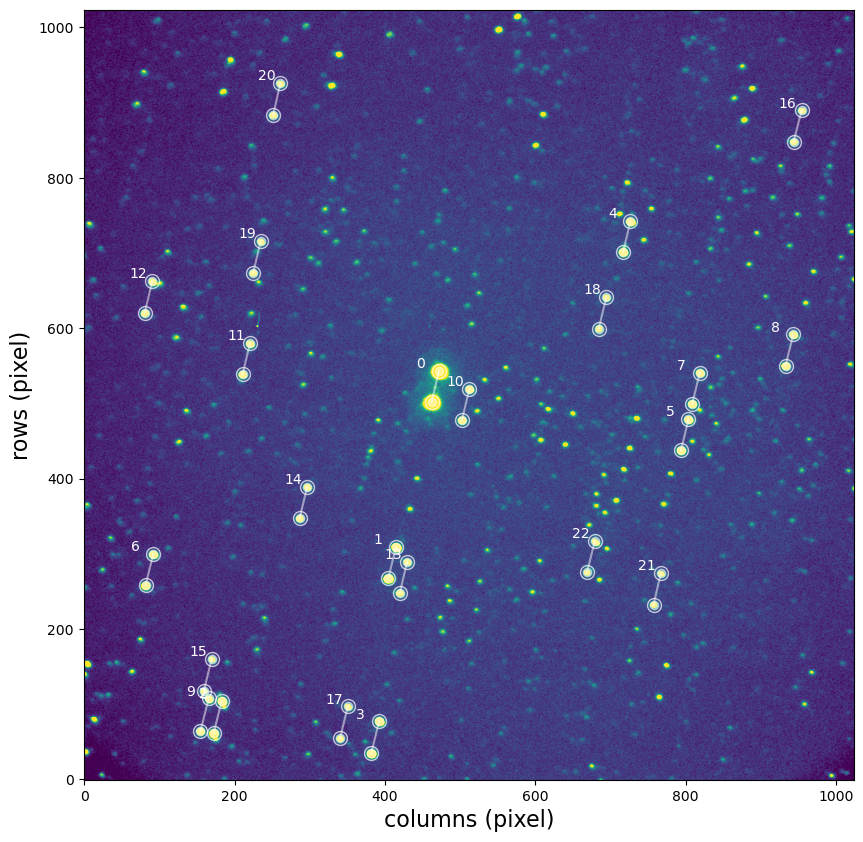

In [16]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l4_list,
                                          reducedir,
                                          stack_suffix=l4_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          plot=True) 

## Calculate `QUARTER-WAVE (L/4)` POLARIMETRY

The quarter-wave ($\lambda/4$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [17]:
# input reduced files list
red_pol_l4_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l4_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l4_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


2024-09-20 11:04:41,121 root - INFO - There is already a polarimetry product :  [pipeline_lib]


2024-09-20 11:04:41,121 | INFO | There is already a polarimetry product :


2024-09-20 11:04:41,244 astropop - INFO - Normalization disabled.  [__init__]


2024-09-20 11:04:41,244 | INFO | Normalization disabled.


2024-09-20 11:04:41,246 root - INFO - Source index: i=0   [pipeline_lib]


2024-09-20 11:04:41,246 | INFO | Source index: i=0 


2024-09-20 11:04:41,247 root - INFO - Source RA=280.006962712479 Dec=-12.401873080180525 mag=-15.9194+-0.0003  [pipeline_lib]


2024-09-20 11:04:41,247 | INFO | Source RA=280.006962712479 Dec=-12.401873080180525 mag=-15.9194+-0.0003


2024-09-20 11:04:41,247 root - INFO - Best aperture radius: 25.0 pixels  [pipeline_lib]


2024-09-20 11:04:41,247 | INFO | Best aperture radius: 25.0 pixels


2024-09-20 11:04:41,247 root - INFO - Polarization in Q: -0.046+-0.001  [pipeline_lib]


2024-09-20 11:04:41,247 | INFO | Polarization in Q: -0.046+-0.001


2024-09-20 11:04:41,248 root - INFO - Polarization in U: -0.017+-0.002  [pipeline_lib]


2024-09-20 11:04:41,248 | INFO | Polarization in U: -0.017+-0.002


2024-09-20 11:04:41,248 root - INFO - Polarization in V: -0.0006+-0.0009  [pipeline_lib]


2024-09-20 11:04:41,248 | INFO | Polarization in V: -0.0006+-0.0009


2024-09-20 11:04:41,248 root - INFO - Total linear polarization p: 0.049+-0.001  [pipeline_lib]


2024-09-20 11:04:41,248 | INFO | Total linear polarization p: 0.049+-0.001


2024-09-20 11:04:41,249 root - INFO - Angle of polarization theta: 100.4+-0.7  [pipeline_lib]


2024-09-20 11:04:41,249 | INFO | Angle of polarization theta: 100.4+-0.7


2024-09-20 11:04:41,249 root - INFO - Free constant k: 1+-nan  [pipeline_lib]


2024-09-20 11:04:41,249 | INFO | Free constant k: 1+-nan


2024-09-20 11:04:41,249 root - INFO - Zero of polarization: 108.7+-0.0  [pipeline_lib]


2024-09-20 11:04:41,249 | INFO | Zero of polarization: 108.7+-0.0


2024-09-20 11:04:41,250 root - INFO - RMS of zi residuals: 0.0019022777138369075  [pipeline_lib]


2024-09-20 11:04:41,250 | INFO | RMS of zi residuals: 0.0019022777138369075


2024-09-20 11:04:41,250 root - INFO - Reduced chi-square (n=16.0, DOF=13.0): 5.43  [pipeline_lib]


2024-09-20 11:04:41,250 | INFO | Reduced chi-square (n=16.0, DOF=13.0): 5.43


2024-09-20 11:04:41,295 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:41,295 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:41,299 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:41,299 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:41,406 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:41,406 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:41,409 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:41,409 | INFO | Substituting symbol \perp from STIXGeneral


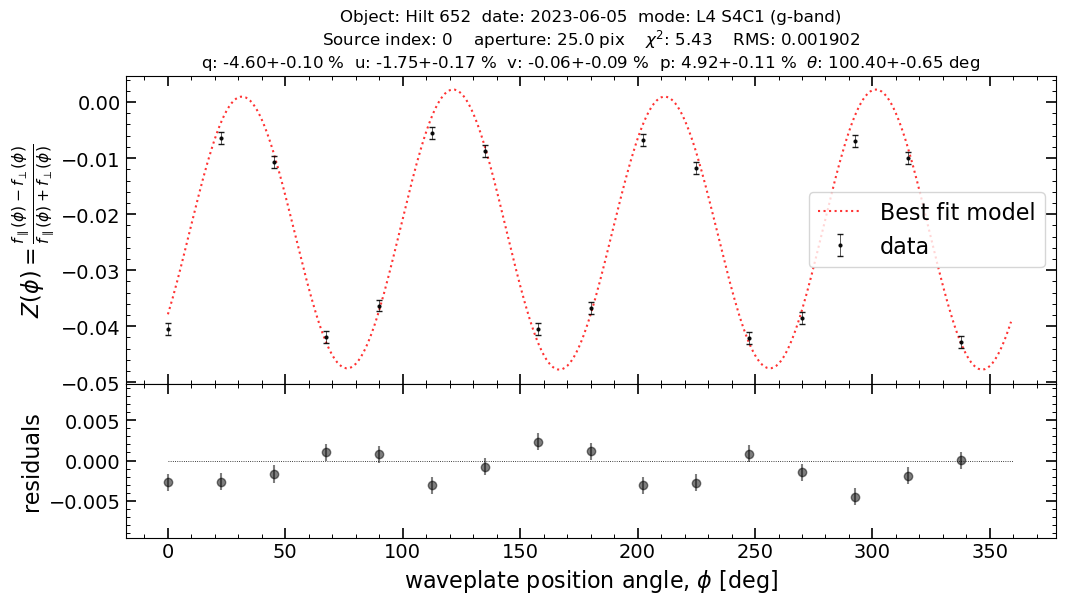

In [18]:
l4_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key='WPPOS',
                                                 wave_plate = 'quarterwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = False,
                                                 fit_zero = True,
                                                 force=FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    l4_polar_products.append(polarproduct)    

## Time series of `QUARTER-WAVE (L/4)` polarimetry data

In [19]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)   

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l4_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

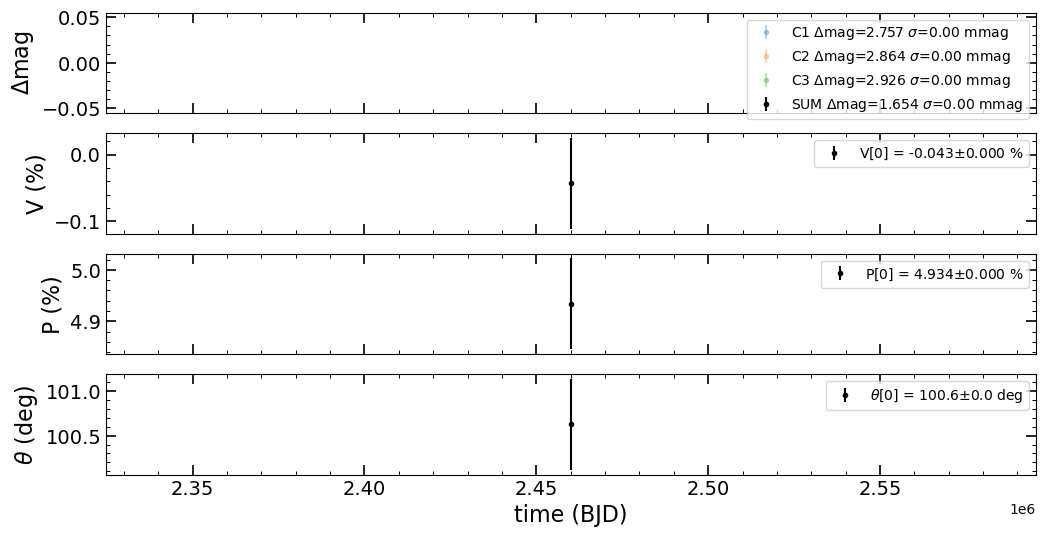

<Table length=1>
diffmag_C00000  diffmag_err_C00000  diffmag_C00001 ...   polarization_2   polarization_2_err
   float64           float64           float64     ...      float64            float64      
-------------- -------------------- -------------- ... ------------------ ------------------
           0.0 0.001328087289004248            0.0 ... 100.62783251612143 0.5147200943398182

In [20]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)